In [59]:
# %pip install 'networkx<2.7'

In [60]:
# !pip install cdlib

In [61]:
import os
import heapq
import argparse
import threading
import multiprocessing
import sys
import queue


from __future__ import division
import math, time
from copy import deepcopy
import multiprocessing, json
from tqdm import tqdm
import heapq
from heapq import nlargest


In [62]:
#importing libraries that will be used
import networkx as nx#for creating network
import numpy as np
import matplotlib.pyplot as plt#for plotting plots

import random
import time#claculating time
import math
from collections import Counter
from itertools import permutations 
from itertools import combinations

from collections import defaultdict
from scipy.io import mmread# to read dataset
import pandas as pd

# from cdlib import algorithms

In [63]:
def celf(graph, k):
    """
    Implementation of CELF algorithm for influence maximization in social networks
    
    Args:
    - graph: NetworkX graph object representing the social network
    - k: number of nodes to select
    
    Returns:
    - nodes: list of k nodes with the highest influence scores
    """
    # Initialize variables
    nodes = []
    heap = []
    marg_gains = {}

    # Calculate the marginal gain for each node
    for node in graph.nodes():
        # Run Monte Carlo simulations to estimate the influence of each node
        sim_res = linear_Threshold(graph, nodes + [node])
        marg_gains[node] = len(sim_res) - len(nodes)
        # Add the node to the heap with its marginal gain as key
        heapq.heappush(heap, (-marg_gains[node], node))

    # Select the k nodes with the highest influence scores
    while len(nodes) < k:
        # Get the node with the highest marginal gain
        _, node = heapq.heappop(heap)
        # Recalculate the marginal gain of the selected node
        sim_res = linear_Threshold(graph, nodes + [node])
        marg_gains[node] = len(sim_res) - len(nodes)
        # Add the node to the list of selected nodes
        nodes.append(node)
        # Update the heap with the new marginal gains
        for n in graph.neighbors(node):
            if n not in nodes:
                heapq.heappush(heap, (-marg_gains[n], n))

    return nodes


In [64]:
def Greedy(G,k):
    print("in Greedy")
    Dict={}
    mySet1=[]
    V=G.nodes()
    mySet1.clear()
    for i in range(k):
        for v in (V-mySet1):
            mySet1.append(v)
            a=linear_Threshold(G,mySet1)
            Dict[v]=len(a)#influence as value and current node as key
            mySet1.remove(v)#remove crrent node from mySet for rest nodes to go for IC
        Keymax = max(zip(Dict.values(), Dict.keys()))[1]# finding node with max influence
        Dict.clear()
        mySet1.append(Keymax)
#     print("Final seed set is:",mySet1,compute_Phi(G,mySet1,comm,k))
    return list(mySet1)


In [65]:
# ratiolevel0bridge=25
# executeDiv()
# processResults()

In [66]:
def read_txt(path):
  file1 = open(path,'r')
  sender = list()
  receiver = list()

  for i in file1.readlines():
    sender.append(int(i.split(' ')[0]))
    receiver.append(int(i.split(' ')[1].split('\n')[0]))
    
  df = pd.DataFrame(list(zip(sender,receiver)),columns =['source', 'target'])
  return df

In [67]:
def gmltotxt(filename):
    import networkx as nx
    import pandas as pd
    g = nx.read_gml('airlines.gml')
    nx.write_edgelist(g, 'edgelistFile.csv', delimiter=',')
    df = pd.read_csv('edgelistFile.csv')
    file = open("myfile.txt","w")
    for i in range(len(df)):
        x=df.iloc[i][0]
        y=df.iloc[i][1]
        file.write(str(x)+" "+str(y)+"\n")
    file.close()

In [68]:
def getcand(G,k, comm):#Take df and  all new nodes as input and return a seed node.
    s=[]
    s=GreedyDiv(G,k, comm)
    return s

In [69]:
def GreedyDiv(G,k, comm):
    Dict={}
    mySet1=[]
    V=G.nodes()
    mySet1.clear()
#     print("Community:",comm,"k:",k)
    for i in range(k):
#         print("myset:",mySet1)
        for v in (V-mySet1):
#             print("v,i:",v,i)
            mySet1.append(v)
#             print("myset:",mySet1)
            a=compute_Phi(G,mySet1,comm,i+1)
#             print("Phi of ",mySet1," is :",a)
            Dict[v]=a#influence as value and current node as key
            mySet1.remove(v)#remove crrent node from mySet for rest nodes to go for IC
               #print(Dict)
        Keymax = max(zip(Dict.values(), Dict.keys()))[1]# finding node with max influence
        Dict.clear()
        mySet1.append(Keymax)
#     print("Final seed set is:",mySet1,compute_Phi(G,mySet1,comm,k))
    return list(mySet1)


In [70]:
def linear_Threshold(graph, seeds):
    influnces = seeds[:]
    queue = influnces[:]
    pre_node_record = defaultdict(float) 
#     print("Queue:",queue)
#     print("Influences:",influnces)
    while len(queue) != 0:
        node = queue.pop(0)
#         print("----------------------------------------------------------------------")
#         print("Take node:",node)
#         print("Neighbour:",graph[node])
        for element in graph[node]:
            if element not in influnces:
#                 print("Element:",element,"prerecored",pre_node_record[element])
                pre_node_record[element] = pre_node_record[element] + graph[node][element]['weight'] 
#                 print(pre_node_record[element])
                if pre_node_record[element] >= graph.nodes[element]['thres']:
#                     print(">>>>>>>>>>>>>>>>>>node influeced:",element)
                    influnces.append(element)
                    queue.append(element)
#     influnce_num = len(influnces)
#     print("Seed set:",seeds,"Activated nodes:",influnces)
    return influnces
# linear_Threshold(GG,[45,29])

In [71]:
def communityDiversityFunction(G, S, communities):
    activated = linear_Threshold(G, S)
    noofcommunity=0
    for com in communities:
#         print(com)
        if any(x in activated for x in com):
            noofcommunity=noofcommunity+1
    return noofcommunity


In [72]:
def compute_Phi(G, S, communities, k):
    if len(S)<1:
        return 0
    lambda_G = 0.5
    
    v_length = G.number_of_nodes()
    diversity_V = communityDiversityFunction(G, list(G.nodes), communities)

    IC_S = linear_Threshold(G, S)
    activated_set_S_length = len(IC_S) 
    diversity_activated_set_S = communityDiversityFunction(G, IC_S, communities)
    phi_S = ((1 - lambda_G)* (activated_set_S_length/v_length)) + (lambda_G * (diversity_activated_set_S/diversity_V))
    return phi_S
    
    
    


In [73]:
def displayresult(result,itr,perc):
    print("\n\n\n\n^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")

    linestylee=['dashdot','dashed','dotted','-', '--', ':','-.' ]
    
    markerss = ['o','v','s','*','+','x','D','d','X','P']
#     descriptions = ['circle', 'triangle_down','square','star', 'plus','x','diamond', 'thin_diamond','x (filled)','plus (filled)']
    communitiesITR=[]
    Name=[]
    activatednodesITR=[]
    timeITR=[]
    tt=[]
    totalcomm=[]
#     print(itr,result)
    
    for i in result:
        for j in range(len(result[i])):
            Name.append(result[i][j]['Name'])
        break
#     print(Name)
    
#     for i in result:
# #         print(result[i])
#         for j in range(len(result[i])):
#             totalcomm.append(result[i][j]['Total communitites'])
#             break
#     print("Total communitites:",totalcomm)
    
    for i in result:
        active=[]
        comm=[]
        tt=[]
        for j in range(len(result[i])):
            active.append(result[i][j]['length of activated nodes'])
            comm.append(result[i][j]['number of communities'])
            tt.append(result[i][j]['time'])
#             print("time:",len(tt),"comm:",len(comm))
        activatednodesITR.append(active)
        communitiesITR.append(comm)
        timeITR.append(tt)
#     print("Activated nodes:",activatednodesITR)
#     print("Communities:",communitiesITR)
#     print("time:",timeITR)
        
    
        
#     print("hello");
    
    plt.xlabel("Percentage")
    plt.ylabel("Activated nodes")
    plt.title("Activated nodes")
    for i in range(len(activatednodesITR[0])):
        plt.plot(perc,[pt[i] for pt in activatednodesITR],label = '%s'%Name[i],linestyle='%s'%linestylee[i],marker='%s'%markerss[i])
    plt.legend()
    plt.show()
    
    
    plt.xlabel("Percentage")
    plt.ylabel("No of community")
    plt.title("Communitites")
    for i in range(len(communitiesITR[0])):
        plt.plot(perc,[pt[i] for pt in communitiesITR],label = '%s'%Name[i],linestyle='%s'%linestylee[i],marker='%s'%markerss[i])
#     plt.plot(perc,totalcomm,label='Total community',linestyle='%s'%linestylee[-1],marker='%s'%markerss[-1])
    plt.legend()
    plt.show()
    
    
    
    
    print("communities:",len(communitiesITR[0]))
    print("Time:",len(timeITR[0]))
    
    plt.xlabel("Percentage")
    plt.ylabel("Execution time:")
    plt.title("Execution time")
    for i in range(len(timeITR[0])):
        plt.plot(perc,[pt[i] for pt in timeITR],label = '%s'%Name[i],linestyle='%s'%linestylee[i],marker='%s'%markerss[i])
#     plt.plot(perc,totalcomm,label='Total community',linestyle='%s'%linestylee[-1],marker='%s'%markerss[-1])
    plt.legend()
    plt.show()
    

In [74]:
def findcommunity(G,seedset,k, comm,algoname,exe_time):
#     print ("Communities formed: ",len(comm))
    activated = linear_Threshold(G, seedset)
    noofcommunity=0
    for com in comm:
        if any(x in activated for x in com):
            noofcommunity=noofcommunity+1
#     print("Community we got:",noofcommunity)
    upperBound_dict = {
        'Name':algoname,
        'k_nodes': k,
#         'Total communitites':len(comm),
        'number of communities':noofcommunity,
        'length of activated nodes': len(activated),
        'time':exe_time,
        # 'length of communities': len(community_df['Unnamed: 1'].unique())
    }
    print(upperBound_dict)
    return upperBound_dict


In [75]:
def findresult(G,k,comm_set_final,prevseedset,G_new):
#     Bridge
    print('\n\n--------------- Bridge (DCDIMB) -------------------')
    BBridgeSeedSet=[]
    st=time.time()
    BBridgeSeedSet = BridgeAlgo(G,int(k),comm_set_final,prevseedset,G_new)
    endtime=time.time()-st
#     print("Bridge:",BBridgeSeedSet)
#     BBridgeSeedSet = sum(Bridge, [])
    BridgeResult=findcommunity(G,BBridgeSeedSet,k, comm_set_final,'Bridge',endtime)
    
    
#     PAGERANK
#     st=time.time()
#     pagerank = sorted(nx.pagerank(G).items(), key=lambda x: x[1], reverse=True)
#     pagerank_seed = [node for node, value in pagerank[0:k]]
#     PRtime=time.time()-st    
#     print('\n\n--------------- PAGERANK -------------------')
#     Pagerankresult=findcommunity(G,pagerank_seed,k, comm_set_final,'PageRank',PRtime)

    #DEGREE
#     st=time.time()
#     degree = sorted(G.degree(), key=lambda x: x[1], reverse=True)
#     degree_seed = [node for node, value in degree[0:k]]
#     Dtime=time.time()-st
#     print('\n\n--------------- DEGREE -------------------')
#     Degreeresult=findcommunity(G,degree_seed,k, comm_set_final,'Degree',Dtime)


#     #HUB
#     st=time.time()
#     hub, authority = nx.hits(G)     
#     hub  = sorted(hub.items(), key=lambda x: x[1], reverse=True)
#     hub_seed = [node for node, value in hub[0:k]]
#     Hubtime=time.time()-st
#     print('\n\n--------------- HUB -------------------')
#     Hubresult=findcommunity(G,hub_seed,k, comm_set_final,'Hub',Hubtime)

#     #AUTHORITY
#     st=time.time()
#     authority  = sorted(authority.items(), key=lambda x: x[1], reverse=True)
#     authority_seed = [node for node, value in authority[0:k]]
#     Atime=time.time()-st
#     print('\n\n--------------- AUTHORITY -------------------')
#     Authorityresult=findcommunity(G,authority_seed,k, comm_set_final,'Authority',Atime)

#     #NBKCORE
#     st=time.time()
#     # neighborhood coreness
#     node2nbcore =  {node: np.sum([G.degree(nb) for nb in G.neighbors(node)]) for node in G.nodes() }
#     nbkcore = sorted(node2nbcore.items(), key=lambda x: x[1], reverse=True)
#     nbkcore_seed = [node for node, value in nbkcore[0:k]]
#     N2time=time.time()-st
#     print('\n\n--------------- neighborhood coreness -------------------')
#     Neighbourresult=findcommunity(G,nbkcore_seed,k, comm_set_final,'Neighbourhood',N2time)
    

#     resultt=[DDR,Greedyresult,CELFresult,Pagerankresult,Degreeresult,Hubresult,Authorityresult,Neighbourresult]
#     resultt=[DDR,SingleDegreeresult,CELFresult,CELFPPresult,Pagerankresult,Degreeresult,Hubresult,Authorityresult,Neighbourresult]
#     resultt=[DDR,Greedyresult,CELFresult,Pagerankresult,Degreeresult,Hubresult,Authorityresult,Neighbourresult]

#     resultt=[TBCDresult,Greedyresult,CELFresult,Pagerankresult,PMIAresult,SIMPATHresult,Degreeresult,FIPresult]
#     resultt=[CELFresult,PMIAresult,Degreeresult,FIPresult,LMPresult,Pagerankresult,SIMPATHresult]

#     resultt=[BridgeResult,CELFresult,PMIAresult,Degreeresult,FIPresult,LMPresult,Pagerankresult]
    
    resultt=[BridgeResult]
#     resultt=[SIMPATHresult,FIPresult,LMPresult]

    return resultt,BBridgeSeedSet

# iteration=1
# ratiolevel0bridge=10
# executeDiv(iteration)
# processResults()

In [76]:
def makeExcel(result,itr,perc):
    timeITR=[]
    Name=[]
    comITR=[]
    activatednodesITR=[]
    for i in result:
        for j in range(len(result[i])):
            Name.append(result[i][j]['Name'])
        break
    for i in result:
        active=[]
        timee=[]
        comm=[]
        for j in range(len(result[i])):
            active.append(result[i][j]['length of activated nodes'])
            comm.append(result[i][j]['number of communities'])
            timee.append(result[i][j]['time'])
        activatednodesITR.append(active)
        comITR.append(comm)
        timeITR.append(timee)
    df=pd.DataFrame()
    com="Community"
    for i in range(len(comITR)):
        comstr=com+"_"+str(itr[i])+"_"+str(perc[i])+"%"
        df[comstr]=comITR[i]
    time="Time"
    for i in range(len(timeITR)):
        timestr=time+"_"+str(itr[i])+"_"+str(perc[i])+"%"
        df[timestr]=timeITR[i]
#     print("After name",df)
    ICnodes="Activated_Nodes"
    for i in range(len(activatednodesITR)):
        ICnodesstr=ICnodes+"_"+str(itr[i])+"_"+str(perc[i])+"%"
        df[ICnodesstr]=activatednodesITR[i]
    df.insert(0,"Name of Algorithm",Name)
    return df


In [77]:
def detect_comm(G):
    # Dictionary to store nodes and their communities
    node_communities = {}
    # Read node-community pairs from the file
    nodess=G.nodes()
    with open(comm_file_path, 'r') as file:
        for line in file:
            # Assuming nodes and communities are separated by space
            node, community = map(int, line.strip().split())
            if community not in node_communities:
                node_communities[community] = set()
            node_communities[community].add(node)
        
    # Convert the dictionary values to a list of sets
    comm_set_final=[]
    for i in node_communities.values():
        comm=list(i)
        comm_set_final.append(comm)
    comm_final= filter_elements(comm_set_final, nodess)
    print("Total communities:",len(comm_final))
    print("Total nodes:",len(nodess))
    return comm_final
        
    
    
    
def filter_elements(list_of_lists, filter_list):
    # Use list comprehension to filter elements from each sublist
    result = [[element for element in sublist if element in filter_list] for sublist in list_of_lists]
    # Remove empty sublists
    result = [sublist for sublist in result if sublist]
    return result

In [78]:
class TBCD_mine(object):
    """
        tree based community detection
    """

    def __init__(self, filename=None, g=nx.Graph(), ttl=float('inf'), obs=7, path="",
                 start=None, end=None, level_max = 6, window_size = 20, theta = 0.5,
                 dataset = None, edge_list = None, comm_list = None,window_ratio = 0.10):
        """
            Constructor
            :param g: networkx graph
            :param ttl: edge time to live (days)
            :param obs: observation window (days)
            :param path: Path where generate the results and find the edge file
            :param start: starting date
            :param end: ending date
        """
        print("initialization")
        self.path = path
        self.graph = g
        self.removed = 0
        self.added = 0
        self.filename = filename
        self.start = start
        self.end = end
        self.obs = obs
        self.communities = {}
        self.intra_conn = {}
        self.inter_conn = {}
        self.select = {}
        self.cluster_head = set()
        self.cluster_h = {}
        self.level = {}
        self.occurence = {}
        self.level_max = level_max
        self.w_temp = 0
        self.window_size = window_size
        self.theta = theta
        self.dataset = ""
        self.edge_list = ""
        self.comm_list = ""
        self.ground_truth_comm = {}
        self.precision = -1
        self.recall = -1
        self.nmi = -1
        self.f_measure = -1
        self.purity = -1
        self.ari = -1
        self.entropy = -1
        self.modularity = -1
        self.coverage = -1
        self.external_density = -1
        self.average_isolability = -1
        self.mat_file_adj = ""
        self.mat_file_label = ""
        self.row = 1
        self.result_array = []
        self.window_ratio = window_ratio


    
    def execute_TBCD_txt(self,file_name,perc,Corenoderatio):
        """
            Execute tree based community detection algorithm from static dataset
        """
        self.edge_list = file_name + '_edge_list.txt'
#         self.comm_list =  file_name + '_comm_list.txt'
    
        edge_list = open(self.edge_list)
#         print("counting edges to set window size")
        window_counter = 0
        count = 0
        for l in edge_list:
            count += 1
#         print("Count:",count,"Window ratio:",self.window_ratio)
        
        self.window_size = int(count*self.window_ratio)        
        self.graph = nx.Graph()

        no_nodes = 0
        w = 0
        edge_list = open(self.edge_list)
        R_seed=[]
        seedSet=[]
        pagerank=[]
        G = nx.DiGraph()
        G_new=nx.DiGraph()
        
        print(count)
        itr=[]
        for i in range(len(perc)):
            vv=int((perc[i]/100)*count)
            itr.append(vv)
        print("Edge number at given checkpoints:",itr)
        totalnodes=0
        resultt={}
        
        for l in edge_list:
#             print(l)
            totalnodes=totalnodes+1
            l = l.split(" ")
#             print(l)
            s=int(l[0])
            t=int(l[1])
            value = round(random.uniform(0.01,1.0),2)
            
            G_new.add_edge(s,t,weight=value)
            
            
            G.add_edge(s,t,weight=value)
            G.nodes[s]['thres']=(G.in_degree(s)/2)
            G.nodes[t]['thres']=(G.in_degree(t)/2)
            k=int(findk(len(G.nodes)))
            
            self.added += 1
            e = {}
            x = int(l[0])
            y = int(l[1])

            
            if totalnodes in itr:
                print("_______________________________________________________________________________________________")
                print("Get result at edge:",totalnodes)
                comm_set_final = detect_comm(G)
                resultt[totalnodes],seedSet=findresult(G,k,comm_set_final,seedSet,G_new)
                G_new.clear()
        displayresult(resultt,itr,perc)
        dff = makeExcel(resultt,itr,perc)
        return dff

    
    


In [79]:
# BridgeDic={}
def GreedyDivv(G,k, comm,Bridge_Graph):
    Dict={}
    mySet1=[]
#     print("Type:",type(Bridge_Graph))
    V=set()
#     V=Bridge_Graph.nodes()
    for e in Bridge_Graph.edges():
        V.add(e[0])
    mySet1.clear()
#     print("V:",V)
#     print("Community:",comm,"k:",k)
    for i in range(k):
#         print("myset Addingggg:",mySet1,type(V))
        for v in (V-set(mySet1)):
#             print("v,i:",v,i,V-set(mySet1))
            mySet1.append(v)
#             print("myset:",mySet1)
            a=compute_Phi(G,mySet1,comm,i+1)
#             print("Phi of ",mySet1," is :",a)
            Dict[v]=a#influence as value and current node as key
            mySet1.remove(v)#remove crrent node from mySet for rest nodes to go for IC
               #print(Dict)
        if(len(Dict)!=0):
            Keymax = max(zip(Dict.values(), Dict.keys()))[1]# finding node with max influence
#             BridgeDic[Keymax]=Dict[Keymax]
            Dict.clear()
            mySet1.append(Keymax)

    return list(mySet1)


In [80]:
def find_Bridge_function(G,bridge_size,community_weight,Previous_seed_set,G_new,comm_set_final):
    print("--------------For bridge nodes------------------------------")
    BridgeGraph=nx.DiGraph()
    
    for edge in G.edges():
        s=edge[0]
        t=edge[1]
        for com in comm_set_final:
            if s in com:
                if t not in com:
                    BridgeGraph.add_edge(s,t,weight=G[s][t]['weight'])
                break;

    BridgeSeedset=GreedyDivv(G,bridge_size,comm_set_final,BridgeGraph)

    return BridgeSeedset
    

    


In [81]:

def SetCore_Bridge_size(ratiolevel0bridge,ksize):
    bridge_size=round((ratiolevel0bridge/100)*ksize)
    core_size=ksize-bridge_size
    

In [82]:
def findSeetset(G,ksize,community_weight,Previous_seed_set,G_new,comm_set_final):
#     Display_Communities(G,comm_set_final)
    seeds=Previous_seed_set
    degrees = G_new.out_degree()  # Compute degrees of all nodes

    sorted_nodes = sorted(degrees, key=lambda x: x[1], reverse=True)  # Sort nodes based on degree in descending order
    top_nodes = [node for node, _ in sorted_nodes[:ksize]]
    seeds=Previous_seed_set+top_nodes
    temp_cand=list(set(seeds))
    
#     bridge_size,core_size=SetCore_Bridge_size(ratiolevel0bridge,ksize)
    bridge_size=round((ratiolevel0bridge/100)*ksize)
    core_size=ksize-bridge_size
    
    print("coresize:",core_size," bridge size:",bridge_size)
    
    Bridge_seed_nodes=find_Bridge_function(G,bridge_size,community_weight,Previous_seed_set,G_new,comm_set_final)
    
    core_size=core_size+(bridge_size-len(Bridge_seed_nodes))
    print("coresize:",core_size," bridge size:",bridge_size)
    print("Bridge seed nodes---------",Bridge_seed_nodes)
    
    Core_seedset=GreedyDivv_find_core_nodes_function(G,core_size,comm_set_final,temp_cand,Bridge_seed_nodes)
#     print("Bridge seed nodes---------",Bridge_seed_nodes)
    print("Core seed nodes---------",Core_seedset)
    
    seedset=Bridge_seed_nodes+Core_seedset
#     print("Overall seed nodes---------",len(seedset),type(seedset),seedset)

    
    return seedset,Bridge_seed_nodes,Core_seedset
    
#     print(G_new,ksize,top_nodes)



In [83]:
# CoreDic={}

def GreedyDivv_find_core_nodes_function(G,k, comm,temp_cand,Bridge_seed_nodes):
#     Display_Communities(G,comm)
#     print("In core---------------")
    Dict={}
    mySet1=set()
    temp=list(set(temp_cand)-set(Bridge_seed_nodes))
#     print("temp:",temp_cand)
#     print("Bridge:",Bridge_seed_nodes)
#     print("target:",temp)
    V=set(temp)
    mySet1.clear()
#     print("Community:",comm,"k:",k)
    for i in range(k):
#         print("myset ADddding:",mySet1)
        for v in (V-mySet1):
#             print("v,i:",v,i)
            mySet1.add(v)
#             print("myset:",mySet1)
            a=compute_Phi(G,list(mySet1),comm,i+1)
#             print("Phi of ",mySet1," is :",a)
            Dict[v]=a#influence as value and current node as key
            mySet1.remove(v)#remove crrent node from mySet for rest nodes to go for IC
               #print(Dict)
        if(len(Dict)!=0):
            Keymax = max(zip(Dict.values(), Dict.keys()))[1]# finding node with max influence
#             CoreDic[Keymax]=Dict[Keymax]
            Dict.clear()
            mySet1.add(Keymax)
    return list(mySet1)

In [84]:
def read_txt(path):
    file1 = open(path,'r')
    sender = list()
    receiver = list()
    for i in file1.readlines():
#         print(int(i.split(' ')[0]),int(i.split('   ')[1]))
        sender.append(int(i.split(' ')[0]))
        receiver.append(int(i.split(' ')[1].split('\n')[0]))
    df = pd.DataFrame(list(zip(sender,receiver)),columns =['source', 'target'])
    df=df.sample(frac=1)
    df.to_csv('input_file_edge_list.txt', sep=' ', index=False,header=False)
    return df
def executeDiv(iteration):
    result_df=pd.DataFrame()
    for i in range(iteration):
        obj=TBCD_mine()
        
        Corenoderatio=[10,20,30,50,60]
        perc=[10,20,30,40,50,60,70,80,90,100]

#         filename='Without_Suffle_dolphin'
        filename='Email_Eu'
        inputt=filename+'_edge_list.txt'
        read_txt(inputt)
        filename='input_file'
        
#         print(inputt)
#         filename='netscience'

        dff=obj.execute_TBCD_txt(filename,perc,Corenoderatio)
        dff2=result_df
        result_df=dff
        result_df = pd.concat([dff2,dff])
        result_df.to_excel('Outputt.xlsx')
        
def processResults(filenamee):
    df = pd.read_excel('Outputt.xlsx')
    df = df.drop(columns='Unnamed: 0')
    print(df.shape)
#     print(df.head(8))
    TBCD = df.loc[df['Name of Algorithm']=='Bridge']
#     Greedy = df.loc[df['Name of Algorithm']=='Greedy']
    FIP = df.loc[df['Name of Algorithm']=='FIP']
    LMP = df.loc[df['Name of Algorithm']=='LMP']
    CELF = df.loc[df['Name of Algorithm']=='CELF']
    PMIA = df.loc[df['Name of Algorithm']=='PMIA']
    SIMPATH = df.loc[df['Name of Algorithm']=='SIMPATH']
    DEGREE = df.loc[df['Name of Algorithm']=='Degree']
    PAGERANK = df.loc[df['Name of Algorithm']=='PageRank']
    
    cols= df.columns
    
#     print(TBCD,FIP,LMP,CELF,PMIA,SIMPATH,DEGREE,PAGERANK)
#     print(TBCD,FIP)
#     ddris = pd.DataFrame(TBCD[cols].mean(),columns = ['Bridge'])
    ddris = pd.DataFrame(TBCD.iloc[:,1:].mean(),columns = ['Bridge'])
#     print("bridge:",ddris)
    fip = pd.DataFrame(FIP.iloc[:,1:].mean(),columns = ['FIP'])
#     print("FIP:",fip)
    lmp = pd.DataFrame(LMP.iloc[:,1:].mean(),columns = ['LMP'])
    celf = pd.DataFrame(CELF.iloc[:,1:].mean(),columns = ['CELF'])
    pmia = pd.DataFrame(PMIA.iloc[:,1:].mean(),columns = ['PMIA'])
    simpath = pd.DataFrame(SIMPATH.iloc[:,1:].mean(),columns = ['SIMPATH'])
    degree = pd.DataFrame(DEGREE.iloc[:,1:].mean(),columns = ['DEGREE'])
    pagerank = pd.DataFrame(PAGERANK.iloc[:,1:].mean(),columns = ['PageRank'])
    
    resultant = pd.concat([ddris,celf,pmia,simpath,degree,pagerank,fip,lmp], axis='columns')
#     resultant = pd.concat([ddris,pmia,simpath,degree,pagerank], axis='columns')
#     print("Resultant:",resultant)
    
    result=resultant.iloc[0:]
#     print("Result:",result)
    
    result.to_excel(filenamee)


In [85]:
def findk(i):#dynamic calculation of k according the percentage of current dataset
  k=(0.03*i)
  
  if(i==0):
    k=1
  if(k>int(k)):
   k=int(k)+1
  return k

In [86]:
def BridgeAlgo(G,k,comm_set_final,Previous_seed_set,G_new):
    community_weight=[]    
    seedSet,Bridge_seed_nodes,Core_seedset=findSeetset(G,k,community_weight,Previous_seed_set,G_new,comm_set_final)
    return seedSet

iteration=5
# ratiolevel0bridge=0
# Result_file_name="As_EW_Bridge_BridgeRatio0_5.xlsx"
# executeDiv(iteration)
# processResults(Result_file_name)

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
1. This code prints the results with respect to different checkpoints i.e. perc=[10,20,30,40,50,60,70,80,90,100]
To get the result the with respect to seed set size change perc=[100] and give seed set size value in function findresult(G,Seed_Sed_Size,comm_set_final,seedSet,G_new)
2. The information of communities is store in "comm_set_final". In the given code, communities are known.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
--------------------------------------
Bridge ration is 40%
\eta value is 3% in findk() function
--------------------------------------
initialization
25571
Edge number at given checkpoints: [2557, 5114, 7671, 10228, 12785, 15342, 17899, 20456, 23013, 25571]
_______________________________________________________________________________________________
Get result at edge: 2557
Total communities: 41
Total nodes: 775


------------

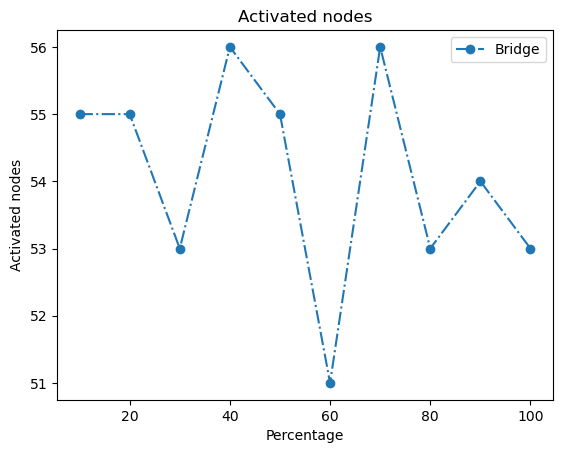

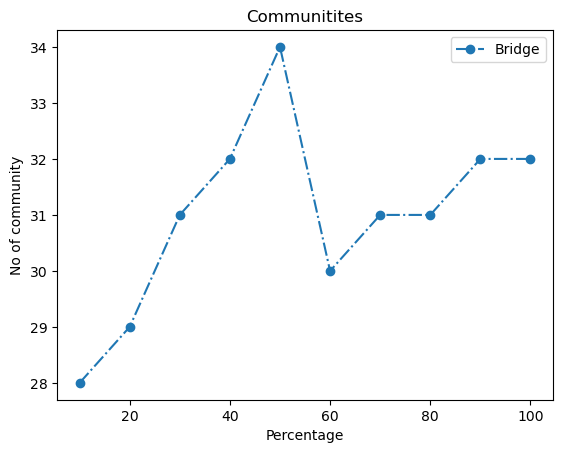

communities: 1
Time: 1


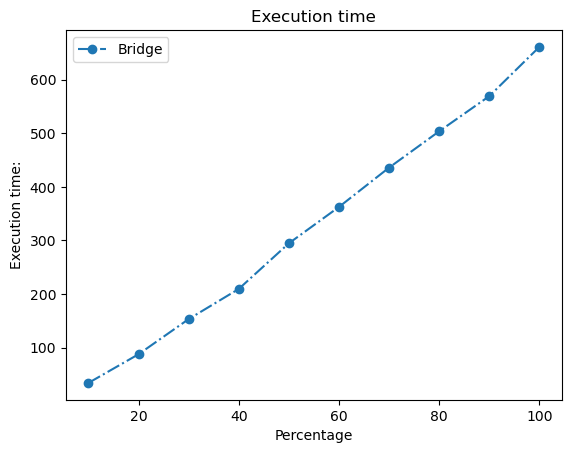

initialization
25571
Edge number at given checkpoints: [2557, 5114, 7671, 10228, 12785, 15342, 17899, 20456, 23013, 25571]
_______________________________________________________________________________________________
Get result at edge: 2557
Total communities: 40
Total nodes: 765


--------------- Bridge (DCDIMB) -------------------
coresize: 14  bridge size: 9
--------------For bridge nodes------------------------------
coresize: 14  bridge size: 9
Bridge seed nodes--------- [397, 169, 64, 58, 340, 249, 121, 748, 546]
Core seed nodes--------- [13, 333, 211, 84, 405, 86, 283, 96, 160, 107, 494, 434, 183, 62]
{'Name': 'Bridge', 'k_nodes': 23, 'number of communities': 30, 'length of activated nodes': 62, 'time': 31.08636784553528}
_______________________________________________________________________________________________
Get result at edge: 5114
Total communities: 40
Total nodes: 856


--------------- Bridge (DCDIMB) -------------------
coresize: 16  bridge size: 10
--------------F

In [ ]:
print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
print("1. This code prints the results with respect to different checkpoints i.e. perc=[10,20,30,40,50,60,70,80,90,100]")
print("To get the result the with respect to seed set size change perc=[100] and give seed set size value in function findresult(G,Seed_Sed_Size,comm_set_final,seedSet,G_new)")
print("2. The information of communities is store in \"comm_set_final\". In the given code, communities are known.")
print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
ratiolevel0bridge=40
print("--------------------------------------")
print("Bridge ration is 40%")
print("\eta value is 3% in findk() function")
print("--------------------------------------")

Result_file_name="As_EW_Bridge_BridgeRatio40_1.xlsx"
comm_file_path="Email_Eu_comm.txt"
executeDiv(iteration)
processResults(Result_file_name)

In [ ]:
# ratiolevel0bridge=100
# Result_file_name="As_EW_Bridge_BridgeRatio100_5.xlsx"
# executeDiv(iteration)
# processResults(Result_file_name)